Generiere Plots...


/tmp/ipykernel_558/4274060686.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


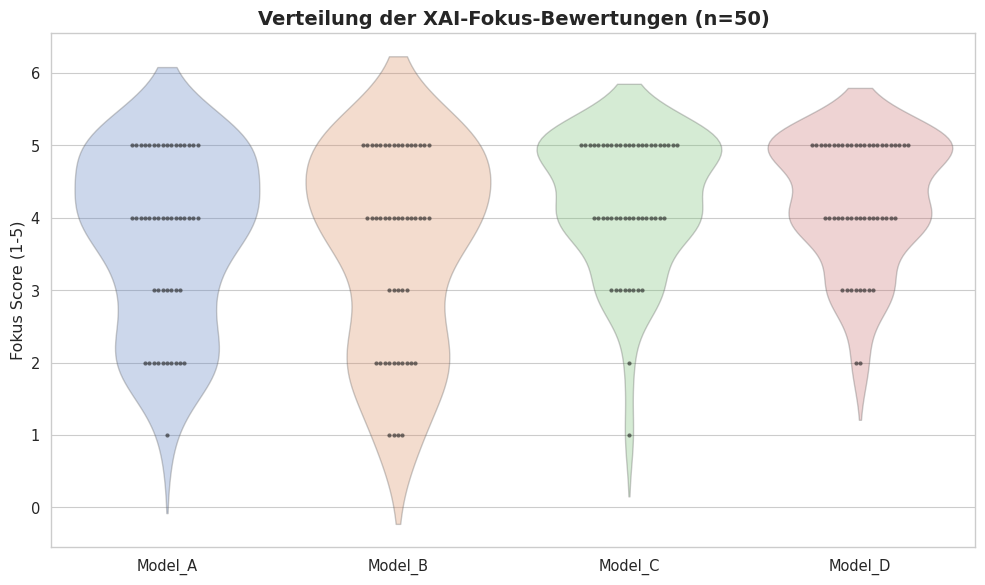

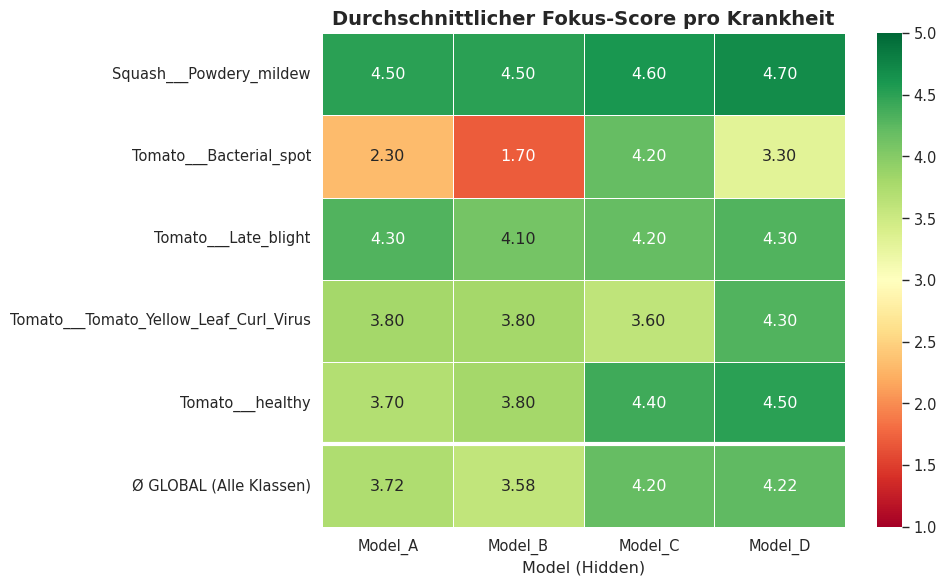


=== STATISTISCHE SIGNIFIKANZ-TESTS ===

1. Friedman-Test (Globaler Vergleich aller 4 Modelle):
   Statistik=14.806, p-Value=0.0020
   -> ERGEBNIS: Signifikante Unterschiede vorhanden!

2. Wilcoxon Signed-Rank Test (Modell A vs. D):
   Statistik=119.500, p-Value=0.005236
   Effektstärke r=0.279 (Interpretation: 0.1=klein, 0.3=mittel, 0.5=groß)
   -> ERGEBNIS: Der Fokus-Shift von A zu D ist statistisch signifikant.

3. Wilcoxon Signed-Rank Test (Modell A vs. B):
   Statistik=88.000, p-Value=0.312545
   Effektstärke r=0.101
   -> ERGEBNIS: Kein signifikanter Unterschied zwischen A und B.

3. Wilcoxon Signed-Rank Test (Modell C vs. D):
   Statistik=216.000, p-Value=0.973350
   Effektstärke r=0.003
   -> ERGEBNIS: Kein signifikanter Unterschied zwischen C und D.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
import numpy as np

# --- KONFIGURATION ---
RATING_FILE = "BEWERTUNGSBOGEN_FINAL.csv"
KEY_FILE = "blind_rating_KEY_FINAL.csv"
OUTPUT_DIR = "./evaluation_plots"

def run_significance_tests(df_clean):
    print("\n=== STATISTISCHE SIGNIFIKANZ-TESTS ===")
    
    # Pivotieren für gepaarte Tests
    df_pivot = df_clean.pivot(index="Image_ID", columns="Model (Hidden)", values="Rating (1=Noise, 3=Mix, 5=Precise)")
    df_pivot_clean = df_pivot.dropna()
    
    # 1. FRIEDMAN TEST (Global)
    # Prüft, ob es IRGENDEINEN Unterschied gibt
    stat, p_value = stats.friedmanchisquare(
        df_pivot_clean["Model_A"], 
        df_pivot_clean["Model_B"], 
        df_pivot_clean["Model_C"], 
        df_pivot_clean["Model_D"]
    )
    
    print(f"\n1. Friedman-Test (Globaler Vergleich aller 4 Modelle):")
    print(f"   Statistik={stat:.3f}, p-Value={p_value:.4f}")
    if p_value < 0.05:
        print("   -> ERGEBNIS: Signifikante Unterschiede vorhanden!")
    else:
        print("   -> ERGEBNIS: Keine signifikanten Unterschiede.")

    # 2. WILCOXON TEST (Baseline A vs. Top-Model D)    
    stat, p_value = stats.wilcoxon(df_pivot_clean["Model_A"], df_pivot_clean["Model_D"])
    
    print(f"\n2. Wilcoxon Signed-Rank Test (Modell A vs. D):")
    print(f"   Statistik={stat:.3f}, p-Value={p_value:.6f}")
    
    # Effektstärke
    n = len(df_pivot_clean) * 2
    z_approx = stats.norm.ppf(p_value/2)
    effect_size_r = abs(z_approx / np.sqrt(n))
    
    print(f"   Effektstärke r={effect_size_r:.3f} (Interpretation: 0.1=klein, 0.3=mittel, 0.5=groß)")
    
    if p_value < 0.05:
        print("   -> ERGEBNIS: Der Fokus-Shift von A zu D ist statistisch signifikant.")
    else:
        print("   -> ERGEBNIS: Kein signifikanter Unterschied.")
        
     # 3. WILCOXON TEST (A vs. B)
    stat_cd, p_value_cd = stats.wilcoxon(df_pivot_clean["Model_A"], df_pivot_clean["Model_B"])
    
    print(f"\n3. Wilcoxon Signed-Rank Test (Modell A vs. B):")
    print(f"   Statistik={stat_cd:.3f}, p-Value={p_value_cd:.6f}")
    
    # Effektstärke berechnen
    n_total = len(df_pivot_clean) * 2  # Gesamtanzahl der Beobachtungen (Paare * 2)
    z_approx_cd = stats.norm.ppf(p_value_cd/2)
    effect_size_r_cd = abs(z_approx_cd / np.sqrt(n_total))
    
    print(f"   Effektstärke r={effect_size_r_cd:.3f}")
    
    if p_value_cd < 0.05:
        print("   -> ERGEBNIS: Signifikanter Unterschied zwischen A und B.")
    else:
        print("   -> ERGEBNIS: Kein signifikanter Unterschied zwischen A und B.")

    # 4. WILCOXON TEST (Low-Data C vs. High-Data D)
    stat_cd, p_value_cd = stats.wilcoxon(df_pivot_clean["Model_C"], df_pivot_clean["Model_D"])
    
    print(f"\n3. Wilcoxon Signed-Rank Test (Modell C vs. D):")
    print(f"   Statistik={stat_cd:.3f}, p-Value={p_value_cd:.6f}")
    
    # Effektstärke berechnen
    n_total = len(df_pivot_clean) * 2  
    z_approx_cd = stats.norm.ppf(p_value_cd/2)
    effect_size_r_cd = abs(z_approx_cd / np.sqrt(n_total))
    
    print(f"   Effektstärke r={effect_size_r_cd:.3f}")
    
    if p_value_cd < 0.05:
        print("   -> ERGEBNIS: Signifikanter Unterschied zwischen C und D.")
    else:
        print("   -> ERGEBNIS: Kein signifikanter Unterschied zwischen C und D.")

   
def evaluate_blind_study_final():
    # 1. Daten laden
    if not os.path.exists(RATING_FILE) or not os.path.exists(KEY_FILE):
        print("FEHLER: Datei fehlt!")
        return

    df_rating = pd.read_csv(RATING_FILE)
    df_key = pd.read_csv(KEY_FILE)

    rating_col = "Rating (1=Noise, 3=Mix, 5=Precise)"
    df_rating[rating_col] = pd.to_numeric(df_rating[rating_col], errors='coerce')

    cols_to_drop = ["Image_ID", "True_Class"]
    for col in cols_to_drop:
        if col in df_rating.columns:
            df_rating = df_rating.drop(columns=[col])

    # 2. Merge
    df_merged = pd.merge(df_rating, df_key, on="Rating_ID (Filename)")
    df_clean = df_merged.dropna(subset=[rating_col])
    
    if len(df_clean) == 0:
        print("Keine Daten.")
        return

    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        
    # Plots
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
    
    print("Generiere Plots...")
    # PLOT 1: VIOLIN PLOT 
    desired_order = ["Model_A", "Model_B", "Model_C", "Model_D"]

    plt.figure(figsize=(10, 6))
    
    # 1. Violinplot mit order
    sns.violinplot(
        data=df_clean, 
        x="Model (Hidden)", 
        y=rating_col, 
        palette="muted", 
        inner=None, 
        alpha=0.3,
        order=desired_order
    )
    
    # 2. Swarmplot AUCH mit order (sehr wichtig, damit es deckungsgleich ist!)
    sns.swarmplot(
        data=df_clean, 
        x="Model (Hidden)", 
        y=rating_col, 
        color="k", 
        size=3, 
        alpha=0.6,
        order=desired_order 
    )
    plt.title("Verteilung der XAI-Fokus-Bewertungen (n=50)", fontsize=14, fontweight='bold')
    plt.ylabel("Fokus Score (1-5)")
    plt.xlabel("")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/01_violin_distribution.png", dpi=300)
    plt.show()
    
    # PLOT 2: HEATMAP PRO KLASSE (Der "Deep Dive")
    heatmap_data = df_clean.pivot_table(
        index="True_Class", 
        columns="Model (Hidden)", 
        values=rating_col, 
        aggfunc="mean"
    )
    
    # GLOBALE DURCHSCHNITTE HINZUFÜGEN 
    global_means = heatmap_data.mean(axis=0)
    heatmap_data.loc['Ø GLOBAL (Alle Klassen)'] = global_means

    # Plotting
    plt.figure(figsize=(10, 6)) 
    ax = sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn", vmin=1, vmax=5, fmt=".2f", linewidths=.5)
    ax.axhline(len(heatmap_data)-1, color='white', linewidth=3)
    
    plt.title("Durchschnittlicher Fokus-Score pro Krankheit", fontsize=14, fontweight='bold')
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/02_heatmap_classes.png", dpi=300)
    plt.show()

    # Statistik ausführen
    run_significance_tests(df_clean)

# Starten
evaluate_blind_study_final()

### Globale Statistiken

In [2]:
def calculate_global_stats(df_clean, rating_col, output_dir):
    print("\n" + "="*40)
    print("GLOBALE MODELL-PERFORMANCE (Alle Klassen)")
    print("="*40)
    
    # Gruppieren und Aggregieren
    global_stats = df_clean.groupby("Model (Hidden)")[rating_col].agg(
        Durchschnitt='mean',
        Median='median',
        Std_Abw='std'
    ).reset_index()
    
    # Schön formatieren (Runden)
    global_stats["Durchschnitt"] = global_stats["Durchschnitt"].round(2)
    global_stats["Std_Abw"] = global_stats["Std_Abw"].round(2)
    
    # Anzeigen
    print(global_stats.to_string(index=False))
    
    # Als CSV speichern (für deine Latex-Tabelle später)
    save_path = f"{output_dir}/global_model_stats.csv"
    global_stats.to_csv(save_path, index=False)
    print(f"\n-> Gespeichert unter: {save_path}")

# --- ANWENDUNG ---
# Falls df_clean noch aus der vorherigen Zelle im Speicher ist:
# calculate_global_stats(df_clean, "Rating (1=Noise, 3=Mix, 5=Precise)", OUTPUT_DIR)

# Falls du es neu laden musst, hier der Quick-Start:
# (Kopiere das nur, wenn df_clean nicht mehr da ist)
import pandas as pd
import os

RATING_FILE = "BEWERTUNGSBOGEN_FINAL.csv"
KEY_FILE = "blind_rating_KEY_FINAL.csv"
OUTPUT_DIR = "./evaluation_plots"
RATING_COL = "Rating (1=Noise, 3=Mix, 5=Precise)"

# Laden & Mergen (wie gehabt)
df_r = pd.read_csv(RATING_FILE)
# Spalten aufräumen um Konflikte zu vermeiden
for col in ["Image_ID", "True_Class"]:
    if col in df_r.columns: df_r = df_r.drop(columns=[col])
        
df_k = pd.read_csv(KEY_FILE)
df_merged = pd.merge(df_r, df_k, on="Rating_ID (Filename)")
df_clean = df_merged.dropna(subset=[RATING_COL])
df_clean[RATING_COL] = pd.to_numeric(df_clean[RATING_COL])

# Berechnung aufrufen
calculate_global_stats(df_clean, RATING_COL, OUTPUT_DIR)


GLOBALE MODELL-PERFORMANCE (Alle Klassen)
Model (Hidden)  Durchschnitt  Median  Std_Abw
       Model_A          3.72     4.0     1.18
       Model_B          3.58     4.0     1.34
       Model_C          4.20     4.0     0.93
       Model_D          4.22     4.0     0.86

-> Gespeichert unter: ./evaluation_plots/global_model_stats.csv
